# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
from sagemaker.pytorch import PyTorchModel
import sagemaker
import boto3
import matplotlib.pyplot as plt
import os
from PIL import Image
import io
from os import listdir
import IPython
from IPython.display import Image as ImageDisplay
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from sagemaker.pytorch import PyTorch
from sagemaker.serializers import IdentitySerializer
from sagemaker.debugger import Rule, ProfilerRule, rule_configs,DebuggerHookConfig,ProfilerConfig, FrameworkProfile
from mpl_toolkits.axes_grid1 import host_subplot
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

[2023-01-23 14:23:34.971 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-01-23 01:53:39--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.0
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.8MB/s    in 24s     

2023-01-23 01:54:13 (44.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affe

In [5]:
session = sagemaker.Session()
bucket= session.default_bucket()
print("default_bucket: {}".format(bucket))

region = session.boto_region_name
print("boto_region_name: {}".format(region))

role = sagemaker.get_execution_role()
print("execution_role: {}".format(role))

default_bucket: sagemaker-us-east-1-722146899913
boto_region_name: us-east-1
execution_role: arn:aws:iam::722146899913:role/service-role/AmazonSageMaker-ExecutionRole-20230119T170320


In [5]:
!aws s3 cp --recursive --quiet ./dogImages 's3://sagemaker-us-east-1-722146899913/data/'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.
hpo = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": IntegerParameter(2, 5)
}

metric_name = "accuracy"
type = "Maximize"
metric_definition = [{"Name": "accuracy", "Regex": "\((\d+)%\)"}]

In [7]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

In [8]:
tuner = HyperparameterTuner(
    estimator,
    metric_name,
    hpo,
    metric_definition,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=type,
)

In [9]:
train = f"s3://{bucket}/data/train"
print(train)
valid = f"s3://{bucket}/data/valid"
print(valid)

s3://sagemaker-us-east-1-722146899913/data/train
s3://sagemaker-us-east-1-722146899913/data/valid


In [10]:
tuner.fit({"train": train, "test": valid})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [11]:
top_estimator = tuner.best_estimator()

top_estimator.hyperparameters()


2023-01-23 15:03:22 Starting - Preparing the instances for training
2023-01-23 15:03:22 Downloading - Downloading input data
2023-01-23 15:03:22 Training - Training image download completed. Training in progress.
2023-01-23 15:03:22 Uploading - Uploading generated training model
2023-01-23 15:03:22 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"accuracy"',
 'batch-size': '"256"',
 'epochs': '5',
 'lr': '0.0017701291124745397',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-01-23-14-23-54-802"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-722146899913/pytorch-training-2023-01-23-14-23-54-802/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "1"}
)

In [13]:
hp = {
    "batch-size": "64",
    "epochs": 3,
    "lr": "0.00716803840042681",
}

In [14]:
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    source_dir=".",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hp,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit({"train": train, "test": valid}, wait=True)

2023-01-23 15:08:46 Starting - Starting the training job...
2023-01-23 15:09:15 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-01-23 15:10:15 Downloading - Downloading input data.........
2023-01-23 15:11:47 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-23 15:11:34,591 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-23 15:11:34,594 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-23 15:11:34,602 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-23 15:11:34,604 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-01-23 15:11:51,848 sagemaker-training-toolkit INFO   

In [15]:
# TODO: Plot a debugging output.
char = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-01-23 15:26:25.142 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-722146899913/pytorch-training-2023-01-23-15-06-13-402/debug-output


In [16]:
def get_inf(char, name, t_mode):
    tensor = char.tensor(name)
    steps = tensor.steps(mode=t_mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=t_mode))
    return steps, vals

In [17]:
def plt_ten(char, name):
    s_train, vals_train = get_inf(char, name, t_mode=ModeKeys.TRAIN)
    s_valid, vals_eval = get_inf(char, name, t_mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(name)

    (p1,) = host.plot(s_train, vals_train, label=name)
    (p2,) = par.plot(s_valid, vals_eval, label="val_" + name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(name)
    
    plt.show()

[2023-01-23 15:26:28.343 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-01-23 15:26:29.371 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:210] Loaded all steps


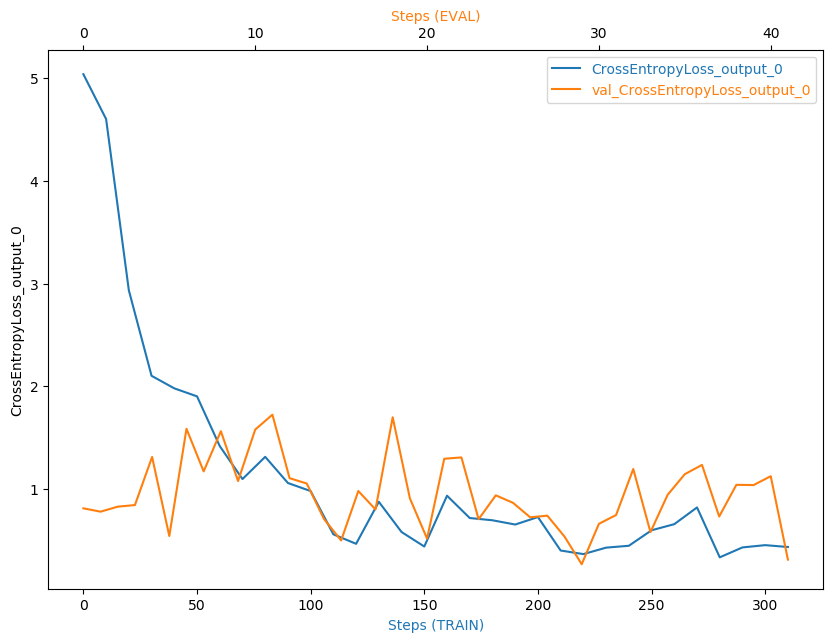

In [18]:
%matplotlib inline
plt_ten(char, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [19]:
# TODO: Display the profiler output
debugging_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
debugging_path

's3://sagemaker-us-east-1-722146899913/pytorch-training-2023-01-23-15-06-13-402/rule-output'

In [20]:
! aws s3 ls {rule_output_path} --recursive


Parameter validation failed:
Invalid bucket name "{rule_output_path}": Bucket name must match the regex "^[a-zA-Z0-9.\-_]{1,255}$" or be an ARN matching the regex "^arn:(aws).*:(s3|s3-object-lambda):[a-z\-0-9]*:[0-9]{12}:accesspoint[/:][a-zA-Z0-9\-.]{1,63}$|^arn:(aws).*:s3-outposts:[a-z\-0-9]+:[0-9]{12}:outpost[/:][a-zA-Z0-9\-]{1,63}[/:]accesspoint[/:][a-zA-Z0-9\-]{1,63}$"


In [21]:
! aws s3 cp {rule_output_path} ./ --recursive


usage: aws s3 cp <LocalPath> <S3Uri> or <S3Uri> <LocalPath> or <S3Uri> <S3Uri>
Error: Invalid argument type


In [31]:
IPython.display.HTML(filename="./profiler-output/profiler-report.html")

## Model Deploying

In [32]:
py_modell = PyTorchModel(model_data=estimator.model_data, 
                             role=role, 
                             entry_point='model.py', 
                             py_version='py36',
                             framework_version='1.8')


predictor = py_modell.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

-----!

In [33]:
predictor.serializer = IdentitySerializer("image/jpeg")

In [34]:
def pred_dog_preed(img):    
    buf = io.BytesIO()
    Image.open(img).save(buf, format="JPEG")
    response = predictor.predict(buf.getvalue())
    
    folders = list(listdir("./dogImages/train"))
    folders.sort()
    return folders[list(response[0]).index(max(response[0]))]

In [35]:
test = "./dogImages/test/132.Xoloitzcuintli/Xoloitzcuintli_08312.jpg"

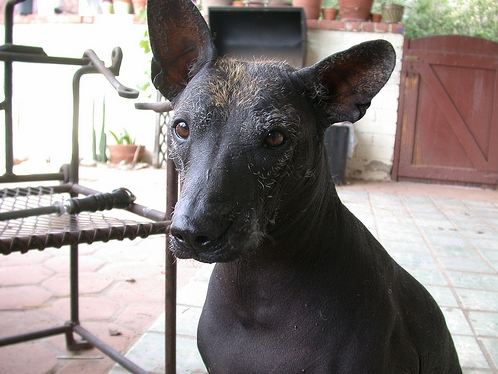

In [36]:
ImageDisplay(test)

In [37]:
pred_dog_preed(test)

'132.Xoloitzcuintli'

In [38]:
test = "./dogImages/test/081.Greyhound/Greyhound_05560.jpg"

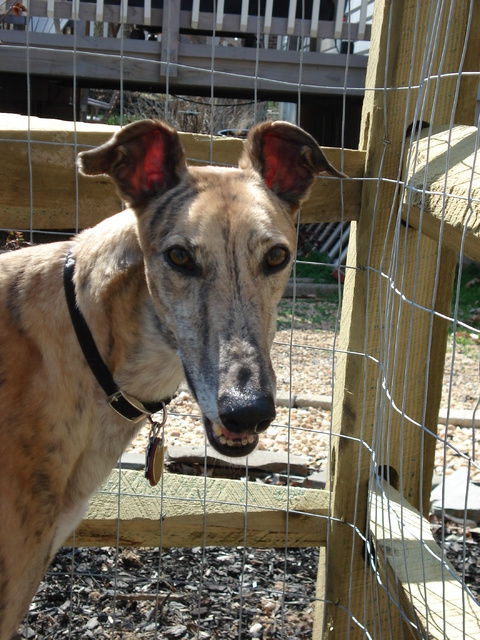

In [39]:
ImageDisplay(test)

In [40]:
pred_dog_preed(test)

'081.Greyhound'

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()